In [3]:

%%capture
import sys

if 'google.colab' in sys.modules:
    # Install packages in Colab
    !pip install category_encoders==2.*
    !pip install eli5
    !pip install pdpbox
    !pip install shap


# 1) 데이터 선정이유와 문제정의 

사용할 데이터는 credit card fraud detection 데이터

신용카드 사기를 탐지하는 모델을 만드는게 불균형 데이터에 대한 공부가 될것 같아서 골랐다 

정상거래인 경우와 사기 거래인 경우 두가지로 나뉘는 분류 문제이다


'V~'컬럼들은 개인정보보호 때문에 PCA 변환의 결과 인 숫자 입력 변수만 포함되어있다 

PCA로 변환되지 않은 컬럼 time(거래시간), amount(거래 금액)

대부분의 거래는 정상이기 때문에 엄청난 불균형 데이터인 특이점이 있다 


In [107]:
# 데이터 불러오기 
import pandas as pd

df = pd.read_csv('/content/drive/MyDrive/section2_project_data/creditcard.csv')

df

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,4.356170,-1.593105,2.711941,-0.689256,4.626942,-0.924459,1.107641,1.991691,0.510632,-0.682920,1.475829,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,-0.975926,-0.150189,0.915802,1.214756,-0.675143,1.164931,-0.711757,-0.025693,-1.221179,-1.545556,0.059616,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,-0.484782,0.411614,0.063119,-0.183699,-0.510602,1.329284,0.140716,0.313502,0.395652,-0.577252,0.001396,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,-0.399126,-1.933849,-0.962886,-1.042082,0.449624,1.962563,-0.608577,0.509928,1.113981,2.897849,0.127434,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0


In [109]:
df.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

import shap
import eli5
from eli5.sklearn import PermutationImportance
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler, RobustScaler,Binarizer
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import make_pipeline,Pipeline
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, StratifiedKFold, cross_val_score,RepeatedStratifiedKFold

from sklearn.metrics import plot_confusion_matrix,confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, roc_auc_score,f1_score, recall_score

The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.


# 2) 데이터를 이용한 가설 및 평가지표, 베이스라인 선택


target = "class" 

이상거래일 경우 - 1 (positive) 아닐경우 - 0 (negative) 인 분류 문제 
사기를 적발하는 것이 목적이기 때문에 99퍼센트의 정확도를 가졌어도 1프로를 예측하지 못하면 의미가 없기 때문에 사기거래를 positive로 둔다 






**사용할 평가지표** -  사기 탐지이기 때문에 재현율이 제일 중요한 지표이다


재현율 - 실제로 사기 인것 중에 모델이 사기라고 올바르게 탐지한 비율
정밀도 - 사기로 분류한것중 실제 사기를 탐지한 비율

재현율과 정밀도는 trade off 관계에 있어 하나를 올리면 하나는 반드시 떨어진다
사기 탐지 문제에서는 

실제로 사기거래이나 정상이라고 잘못 판단 했을때의 리스크가 크기 때문에 재현율이 더 중요하게 여겨지나, 정상 거래를 사기로 잘못 판단 했을때의 고객 불만도 생각해야 하기 때문에 적절한 threshold를 찾아가는게 중요하다

추가로 precision, F1 score를 사용할 예정


갯수
 0    284315
1       492
Name: Class, dtype: int64

비율
 0    99.827251
1     0.172749
Name: Class, dtype: float64


Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


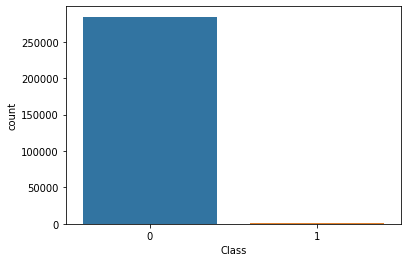

In [6]:
# 먼저 타겟의 분포를 알아보자 
print('갯수\n',df['Class'].value_counts())

print('\n비율\n',df['Class'].value_counts (normalize = True) * 100)

sns.countplot(df['Class']) # 타겟분포 시각화 

사기는 자주 발생하지 않기 때문에 기존분포 자체가 엄청나게 낮다 


하지만 우리는 탐지가 목적이기에 클래스의 비율을 맞춰줘야 올바른 예측을 하는 모델을 만들 수 있을 것이다 

후에 비율을 조정하고 베이스라인 모델을 다시 만들어야 겠다 

# 3) EDA 및 데이터 전처리

In [ ]:
df.isnull().sum().sum() # 결측치 없음 

0

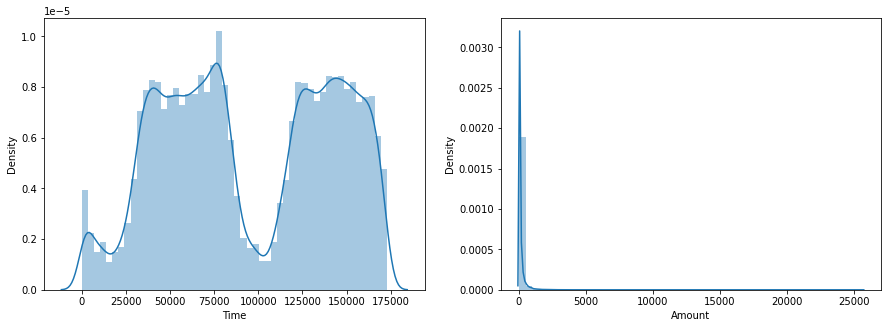

In [ ]:
# time, amount 분포도 시각화 

fig, ax = plt.subplots(1, 2, figsize=(15,5))

sns.distplot(df['Time'],ax=ax[0]) # 거래 시간 분포도
sns.distplot(df['Amount'],ax=ax[1]) # 거래 금액 분포도 

# 스케일링 필요


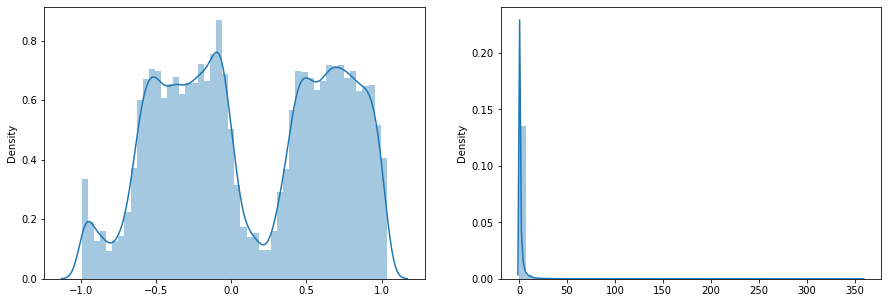

In [ ]:
# 이상치에 둔감하게 작용하는 robust 스케일러 적용해봄

scaler = RobustScaler()

# 로버스트 스케일러 
amount = scaler.fit_transform(df['Amount'].values.reshape(-1,1))
time = scaler.fit_transform(df['Time'].values.reshape(-1,1))

fig, ax = plt.subplots(1, 2, figsize=(15,5))

sns.distplot(time,ax=ax[0])
sns.distplot(amount,ax=ax[1])
# 스케일링되어 분포가 줄어든것 확인 가능 
# amount은 왼쪽으로 쏠려있는 형태지만 타겟이 아니고 피쳐이고, 분류문제이기 때문에 여기서는 스케일러만 적용 
# 후에 파이프라인을 통해서 스케일링 할 예정이다 

# 다운샘플링

대부분의 거래가 정상거래인 불균형 데이터이기 때문에 대부분 정상이라고 예측하게 된다(overfitting) 

사기 데이터에 가중치를 줘서 비율을 맞춰줘야 한다 > 다운&업샘플링을 해보자


In [7]:
# 다운샘플링 함수 

def downsampled(df):
    df_normal = df[df.Class==0] # 클래스가 0인것 - 정상
    df_fraud = df[df.Class==1] # 클래스가 1인것 - 사기 

    df_normal_downsampled = df_normal.sample(frac=1,random_state=0)[:df_fraud.shape[0]] # 노멀데이터를 fraud와 같은 갯수로 샘플링 (셔플)
    df = pd.concat([df_normal_downsampled, df_fraud]) # 샘플링한 데이터를 다시 합침 
    print(df.Class.value_counts()) # 클래스별 데이터 개수 
    return df


In [15]:
# 다운샘플 적용한 train, val, test 데이터 나누는 함수 
def downsampled_data_split(df):

    # 먼저 다운샘플링 적용전 훈련, 검증, 테스트 셋으로 나눠준다 
    # 테스트셋의 분포가 누수되면 안되기 때문이다 
    train, test = train_test_split(df, train_size = 0.8, random_state=2)
    train, val = train_test_split(train, train_size = 0.8, random_state=2)
    print(train.shape[0], val.shape[0], test.shape[0])

    # 다운샘플 적용 
    train = downsampled(train)

    target = 'Class' # 타겟 
    features = df.columns.drop('Class') # 피쳐 

    X_train = train[features]
    y_train = train[target]
    X_val = val[features]
    y_val = val[target]
    X_test = test[features]
    y_test = test[target]
    return X_train, X_val, X_test, y_train, y_val, y_test


In [49]:
# 다운샘플 적용한 훈련, 검증, 테스트 셋 얻기 
df_down = df.copy()
X_train_down, X_val_down, X_test_down, y_train_down, y_val_down, y_test_down = downsampled_data_split(df_down)
X_train_down.shape, X_val_down.shape

182276 45569 56962
1    332
0    332
Name: Class, dtype: int64


((664, 30), (45569, 30))

In [21]:
baseline = y_train.value_counts(normalize = True)[0] 
print('베이스라인 모델 : ',baseline *100 ,'%')


베이스라인 모델 :  50.0 %


In [22]:
# 모델링 및 스코어 함수 
def modeling(model, X_train, X_test, y_train, y_test):
    pipe = Pipeline([('scale',RobustScaler()), 
                    ('model',model)])
    pipe.fit(X_train, y_train)
    pred = pipe.predict(X_test)
    print('훈련 정확도 : ', accuracy_score(y_train,pipe.predict(X_train)))
    print('검증 정확도 : ', accuracy_score(y_test,pred))
    print('\n',classification_report(y_test, pred)) # 스코어 


In [86]:
# 모델링 및 스코어 함수 
def modeling_cv(model, X_train, X_test, y_train, y_test):
    pipe = Pipeline([('scale',RobustScaler()), 
                    ('model',model)])
    pipe.fit(X_train, y_train)
    pred = pipe.predict(X_test)
    print('훈련 교차검증 : ',(cross_val_score(pipe, X_train, y_train, cv=5)))
    print('테스트 교차검증 : ', (cross_val_score(pipe, X_test, y_test, cv=5)))
    print('훈련 교차검증 평균 :', (cross_val_score(pipe, X_train, y_train, cv=5).mean()))
    print('테스트 교차검증 평균 : ',(cross_val_score(pipe, X_test, y_test, cv=5).mean()))
    print('훈련 정확도 : ', accuracy_score(y_train,pipe.predict(X_train)))
    print('테스트 정확도 : ', accuracy_score(y_test,pred))
    print('\n',classification_report(y_test, pred)) # 스코어 


In [50]:
# 다운샘플 적용 후 모델 돌려보기 
lr = LogisticRegression(random_state=2)
dt = DecisionTreeClassifier(random_state=2)
xg = XGBClassifier(random_state=2)

modeling(lr,X_train_down, X_val_down, y_train_down, y_val_down) # 로지스틱 
# 학습은 클래스가 50:50의 비율로 하고 검증은 비율이 안맞는 원래데이터로 해서 정밀도가 낮게 나온다

훈련 정확도 :  0.9503012048192772
검증 정확도 :  0.9768263512475587

               precision    recall  f1-score   support

           0       1.00      0.98      0.99     45493
           1       0.06      0.83      0.11        76

    accuracy                           0.98     45569
   macro avg       0.53      0.90      0.55     45569
weighted avg       1.00      0.98      0.99     45569



# 오버샘플링

In [27]:
# 오버샘플링 시도  
# SMOTE를 사용한 오버 샘플링 

from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=0)

target = df['Class']
features = df.drop('Class',axis=1)

X_train, X_test, y_train, y_test = train_test_split(features, target, train_size=0.8, random_state=2)
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train, train_size=0.8, random_state=2)

X_train, y_train = smote.fit_sample(X_train, y_train)

X_train.shape, y_train.shape

The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.


((363888, 30), (363888,))

In [28]:
modeling(lr,X_train, X_val, y_train, y_val ) # 로지스틱 다운샘플링보다 좀 나은 수치?

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


훈련 정확도 :  0.9820109484236909
검증 정확도 :  0.9903443130198161

               precision    recall  f1-score   support

           0       1.00      0.99      1.00     45493
           1       0.13      0.84      0.23        76

    accuracy                           0.99     45569
   macro avg       0.56      0.92      0.61     45569
weighted avg       1.00      0.99      0.99     45569



**샘플링으로 비율을 맞춰 줬으니 피쳐들의 상관관계 및 중요도를 확인해보자**

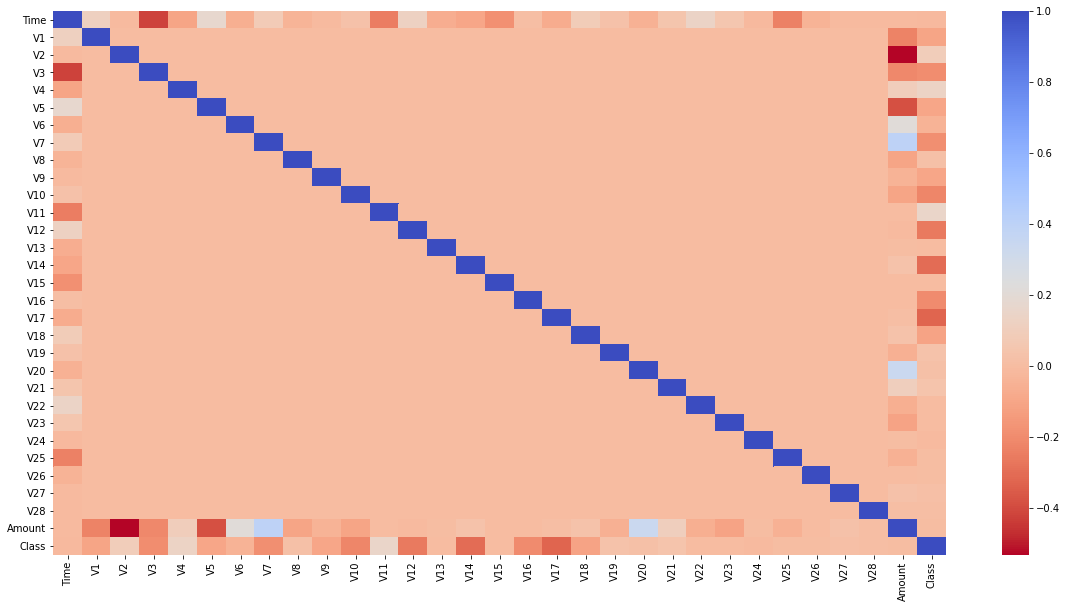

In [ ]:
# 먼저 히트맵 시각화 
f, ax = plt.subplots(1, 1, figsize=(20,10))

sns.heatmap(df.corr(), cmap='coolwarm_r', annot_kws={'size':20}) 
# 12, 14, 17 양의 상관관계
# 2, 4, 11 음의 상관관계

순열중요도는 변수들이 서로 상관관계가 있을경우 부정확해질수 있지만 shap는 특성 기여도에 기반을 둬서 중요도를 골라내 피쳐끼리의 영향을 받지 않는 장점이 있다 

여기서는 shap을 사용해서 피쳐중요도를 살펴보자

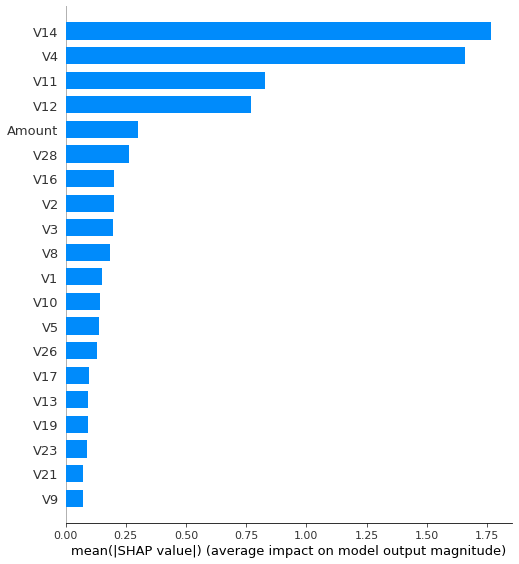

In [29]:
explainer = shap.TreeExplainer(xg) # XGboost 넣기
shap_values = explainer.shap_values(features) #  shap value 얻기 

shap.initjs()

# shap 시각화로 feture importance 확인 하기 
shap.summary_plot(shap_values, features, plot_type='bar')

# 히트맵에서 확인했던 피쳐들이 대부분 상위권에 랭크 되어있다

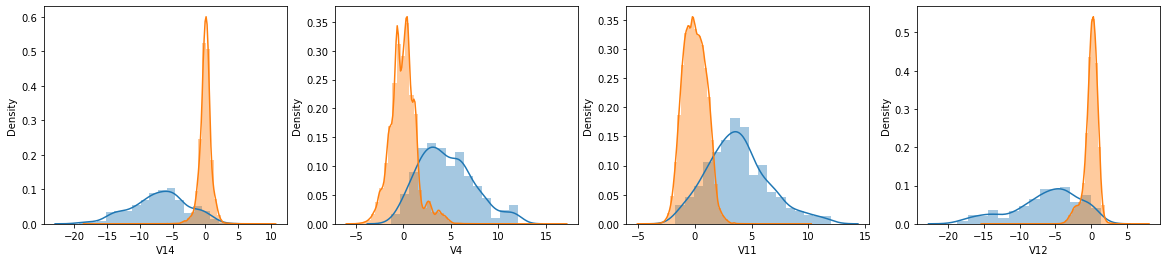

In [ ]:
# 중요도높은 피쳐들 분포 확인 
f, axes = plt.subplots(ncols=4, figsize=(20,4))

# class 0과 1이 분포가 매우 달라서 클래스를 예측하는데 좋기 때문에 영향력이 높은 피쳐라 나온것으로 보인다 
sns.distplot(df['V14'].loc[df['Class']==1], ax=axes[0])
sns.distplot(df['V14'].loc[df['Class']==0], ax=axes[0])

sns.distplot(df['V4'].loc[df['Class']==1], ax=axes[1])
sns.distplot(df['V4'].loc[df['Class']==0], ax=axes[1])

sns.distplot(df['V11'].loc[df['Class']==1], ax=axes[2])
sns.distplot(df['V11'].loc[df['Class']==0], ax=axes[2])

sns.distplot(df['V12'].loc[df['Class']==1], ax=axes[3])
sns.distplot(df['V12'].loc[df['Class']==0], ax=axes[3])

plt.show()

히트맵과 분포도를 대략 살펴봤으니 중요한 컬럼에 이상치 제거를 해보자 

이상치 제거는 타겟과 상관관계가 높은 열을 우선적으로 진행한다

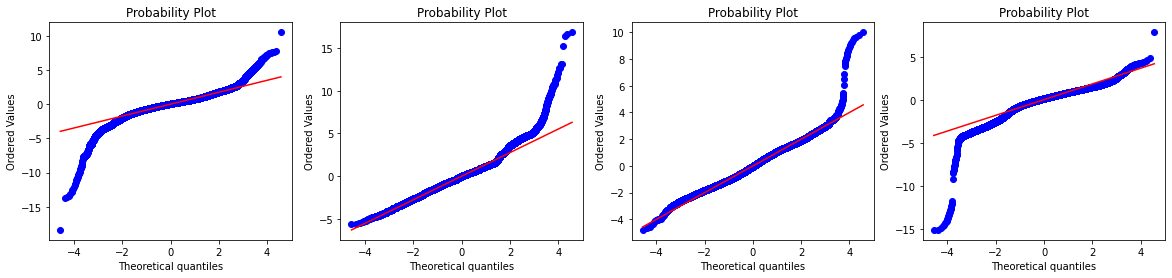

In [37]:
# 이상치 확인을 위해 컬럼을 더 자세히 살펴보자 

from scipy.stats import probplot

# class 0 일 때  qqplot

f, axes = plt.subplots(ncols=4, figsize=(20,4))

probplot(df['V14'].loc[df['Class']==0],plot=axes[0])

probplot(df['V4'].loc[df['Class']==0],plot=axes[1])

probplot(df['V11'].loc[df['Class']==0],plot=axes[2])

probplot(df['V12'].loc[df['Class']==0],plot=axes[3])

plt.show()

# 14에서 높은값/ 낮은값 한포인트, 4에서 높은값, 12에서 높은값 하나

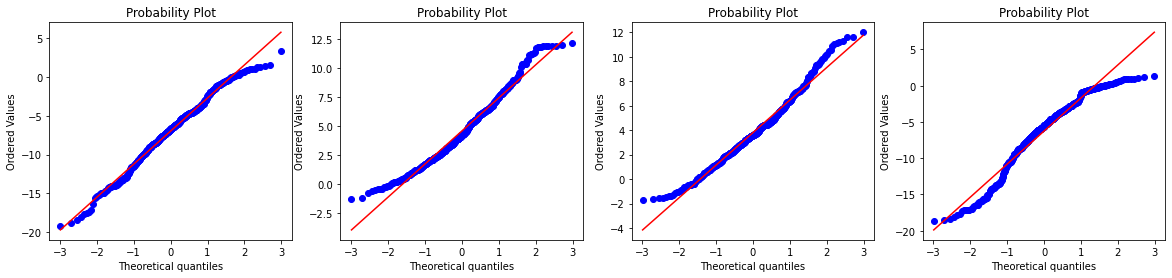

In [ ]:
# class 1 일때 qqplot 
f, axes = plt.subplots(ncols=4, figsize=(20,4))

probplot(df['V14'].loc[df['Class']==1],plot=axes[0])

probplot(df['V4'].loc[df['Class']==1],plot=axes[1])

probplot(df['V11'].loc[df['Class']==1],plot=axes[2])

probplot(df['V12'].loc[df['Class']==1],plot=axes[3])
plt.show()

# 어떠한 패턴을 띄고 있지 특별히 이상치라고 부를만한게 크게는 없어 보이는듯? 

In [30]:
# 위에서 본거 바탕으로 이상치 제거 

v14_out = df['V14'].loc[df['Class']==0].sort_values(ascending=False).head(3).values
v14_out_low = df['V14'].loc[df['Class']==0].sort_values(ascending=True).head(3).values
v4_out = df['V4'].loc[df['Class']==0].sort_values(ascending=False).head(4).values
v12_out = df['V12'].loc[df['Class']==0].sort_values(ascending=False).head(2).values

print(v14_out,v14_out_low,v4_out, v12_out)

[10.52676605  7.75459875  7.69220854] [-18.3920915  -13.78037749 -13.62409157] [16.87534403 16.71553737 16.49121717 15.30418399] [7.84839208 4.84645241]


In [31]:
outlier = (df['V14'] != v14_out[0]) & (df['V14'] != v14_out_low[0]) & (df['V4'] <15)  & (df['V12'] != v12_out[0]) 
df_copy= df.copy() 
df_copy = df_copy[outlier]
df.shape[0],df_copy.shape[0] # 6개 제거

(284807, 284801)

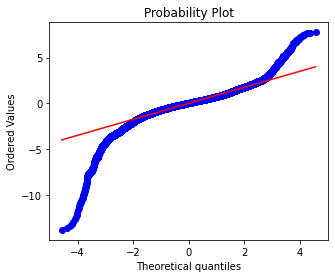

In [42]:
# V14 컬럼에서 outlier 지워진것 확인가능
f, axes = plt.subplots(ncols=1, figsize=(5,4))
probplot(df_copy['V14'].loc[df_copy['Class']==0],plot=axes)
plt.show()

In [32]:
# shap 중요도 데이터프레임으로 만듬 
feature_importance = pd.DataFrame(np.abs(shap_values).mean(0),features.columns.tolist(),columns=['value'])
ft_list= feature_importance.sort_values(by='value',ascending=True)[:10].index # 하위 10개 리스트 

# 중요도 하위10개 피쳐 삭제작업 
df_removed = df_copy.drop(ft_list,axis=1)
df_removed.shape[1] # 하위 10 피쳐가 삭제된것을 볼 수 있다 

21

In [51]:
# 아웃라이어와 피쳐 삭제한 df로 다시 데이터 나누고 다운샘플링  
X_train_down, X_val_down, X_test_down, y_train_down, y_val_down, y_test_down = downsampled_data_split(df_down)
X_train_down.shape, X_val_down.shape

182276 45569 56962
1    332
0    332
Name: Class, dtype: int64


((664, 30), (45569, 30))

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


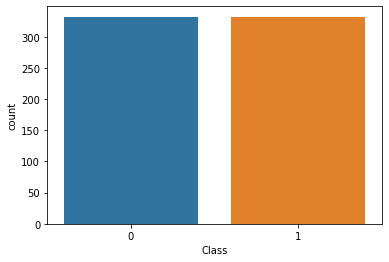

In [45]:
sns.countplot(y_train_down) # 다운샘플링후 클래스 비율 동일 

In [43]:
# 아웃라이어와 피쳐 삭제한 데이터로 다시 데이터 나누고 오버샘플링 

smote = SMOTE(random_state=0)

y = df_removed['Class']
X = df_removed.drop('Class',axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=2)
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train, train_size=0.8, random_state=2)

X_train, y_train = smote.fit_sample(X_train, y_train)

X_train.shape, y_train.shape

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.


((363904, 20), (363904,))

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


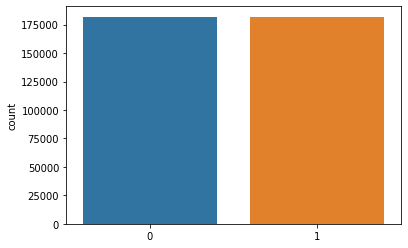

In [44]:
sns.countplot(y_train) # 업샘플링후 클래스 비율 동일 

In [46]:
# 다운샘플링 모델들 돌려보기 
modeling(lr, X_train_down, X_val_down, y_train_down, y_val_down) # 로지스틱
modeling(dt, X_train_down, X_val_down, y_train_down, y_val_down) # 결정트리
modeling(xg, X_train_down, X_val_down, y_train_down, y_val_down) # xgboost 
# 정확도는 높으나 f1 score와 정밀도가 매우 낮음 
# 트리모델은 과적합이 보인다 

훈련 정확도 :  0.9503012048192772
검증 정확도 :  0.9768263512475587

               precision    recall  f1-score   support

           0       1.00      0.98      0.99     45493
           1       0.06      0.83      0.11        76

    accuracy                           0.98     45569
   macro avg       0.53      0.90      0.55     45569
weighted avg       1.00      0.98      0.99     45569

훈련 정확도 :  1.0
검증 정확도 :  0.9090390396980403

               precision    recall  f1-score   support

           0       1.00      0.91      0.95     45493
           1       0.02      0.88      0.03        76

    accuracy                           0.91     45569
   macro avg       0.51      0.90      0.49     45569
weighted avg       1.00      0.91      0.95     45569

훈련 정확도 :  1.0
검증 정확도 :  0.9694090280673264

               precision    recall  f1-score   support

           0       1.00      0.97      0.98     45493
           1       0.04      0.86      0.09        76

    accuracy                    

In [47]:
# 업샘플링 모델들 돌려보기
modeling(lr, X_train, X_val, y_train, y_val) # 로지스틱
modeling(dt, X_train, X_val, y_train, y_val) # 결정트리
modeling(xg, X_train, X_val, y_train, y_val) # xgboost 
# 다운샘플링은 데이터크기를 많이 줄여서 그런지 전반적 점수는 업샘플링이 더 높은편이다

훈련 정확도 :  0.9591732984523391
검증 정확도 :  0.9808857092696629

               precision    recall  f1-score   support

           0       1.00      0.98      0.99     45492
           1       0.07      0.89      0.14        76

    accuracy                           0.98     45568
   macro avg       0.54      0.94      0.56     45568
weighted avg       1.00      0.98      0.99     45568

훈련 정확도 :  1.0
검증 정확도 :  0.9971251755617978

               precision    recall  f1-score   support

           0       1.00      1.00      1.00     45492
           1       0.35      0.82      0.49        76

    accuracy                           1.00     45568
   macro avg       0.67      0.91      0.74     45568
weighted avg       1.00      1.00      1.00     45568

훈련 정확도 :  0.983630298100598
검증 정확도 :  0.9892468398876404

               precision    recall  f1-score   support

           0       1.00      0.99      0.99     45492
           1       0.12      0.91      0.22        76

    accuracy      

Data Leakage가 있었나요? 없었다면 어떻게 방지했나요?

- 샘플링 전에 train, val, test 셋을 나눠 주었고, 모델 학습시 파이프라인을 사용하여 데이터 누수가 일어나지 않게 만들었다 

조하진님이 만들고자 하는 모델은 언제 유용한가요? 어떤 한계를 가지고 있나요?

- 다운 & 업샘플링을 통해 불균형 데이터의 균형을 맞춰줌으로 좀 더 fraud 탐지에 초점이 맞춰진 모델을 만들 수 있다 
- 하지만 다운샘플링은 마이너 클래스에 데이터 개수를 맞춰주다보니, 메이저 클래스 데이터가 많이 삭제되서 데이터수 자체가 줄어들고 완전히 동일한 분포를 가져올 수 없다는 것이 한계점이다
- 업샘플링은 마이너 클래스를 메이저 클래스로 올려주지만, 가상으로 만들다 보니 현실과 약간의 차이점이 있을 수 도 있다는 것이 단점이다
- 샘플링을 해줌으로서 마이너클래스가 상대적으로 엄청나게 적은 데이터를 분석하는데 유용하다
- 또한 사기탐지이므로 재현율을 많이 보기 때문에 재현율이 중요한 분석에 유용하다(예: 질병판단. 정상을 비정상이라고 하는 것보다 비정상을 정상이라고 하는것이 더 리스크가 클 때)

# 머신러닝 방식 적용 및 교차검증

**하이퍼 파라미터 튜닝**


In [52]:
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train) # 학습데이터


In [53]:
# 업샘플링 데이터 로지스틱 하이퍼 파라미터 튜닝

lr_model = LogisticRegression(random_state=2)

lr_model.fit(X_train_scaled, y_train)

solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01]

grid = dict(solver=solvers,penalty=penalty,C=c_values)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

lr_clf = GridSearchCV(
    lr_model, 
    param_grid=grid, 
    cv=cv,
    scoring='accuracy',
    error_score=0,
    n_jobs=-1
)

lr_clf.fit(X_train_scaled, y_train)

GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=3, n_splits=10, random_state=1),
             error_score=0,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=2, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'C': [100, 10, 1.0, 0.1, 0.01], 'penalty': ['l2'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=0)

In [54]:
print('logistic 최적 하이퍼파라미터 : ', lr_clf.best_params_)
print('logistic score : ', lr_clf.best_score_)

logistic 최적 하이퍼파라미터 :  {'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
logistic score :  0.9592722243457845


In [55]:
# 찾은값 적용 
lr_tuning = LogisticRegression(C=100,  solver='lbfgs', random_state=2)

modeling(lr_tuning,X_train, X_val, y_train, y_val)

훈련 정확도 :  0.9593079493492789
검증 정확도 :  0.9806004213483146

               precision    recall  f1-score   support

           0       1.00      0.98      0.99     45492
           1       0.07      0.89      0.13        76

    accuracy                           0.98     45568
   macro avg       0.54      0.94      0.56     45568
weighted avg       1.00      0.98      0.99     45568



In [69]:
# 트리모델에서 과적합이 보였던 다운샘플링 데이터로 XGboost 하이터파라미터 튜닝 
X_train_down_scaled = scaler.fit_transform(X_train_down) # 학습데이터

model = XGBClassifier(random_state=2)

# 하이퍼 파라미터 튜닝을위한 randomizeCV 
dists = {'max_depth': range(4,8),
    'learning_rate': [0.001, 0.01, 0.1, 0.2],
    'sub_sample' : [0.5, 0.75, 1.0]
}

clf = RandomizedSearchCV(
    model, 
    param_distributions=dists, 
    n_iter=50, 
    cv=5, 
    scoring='neg_log_loss',  
    verbose=1,
    n_jobs=-1
)

clf.fit(X_train_down_scaled, y_train_down)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


The total space of parameters 48 is smaller than n_iter=50. Running 48 iterations. For exhaustive searches, use GridSearchCV.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:   27.1s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:   31.2s finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1, gamma=0,
                                           learning_rate=0.1, max_delta_step=0,
                                           max_depth=3, min_child_weight=1,
                                           missing=None, n_estimators=100,
                                           n_jobs=1, nthread=None,
                                           objective='binary:logistic',
                                           random_state=2, reg_alpha=0,
                                           reg_lambda=1, scale_pos_weight=1,
                                           seed=None, silent=None, subsample=1,
                                           verbosity=1),
                   iid='de

In [70]:
print('XGboost 최적 하이퍼파라미터 : ', clf.best_params_)
print('XGboost log loss : ', -clf.best_score_)

XGboost 최적 하이퍼파라미터 :  {'sub_sample': 0.5, 'max_depth': 5, 'learning_rate': 0.1}
XGboost log loss :  0.19755496654395355


In [71]:
# 찾은값 적용 
xg_tuning = XGBClassifier(sub_sample=0.5, max_depth=5,learning_rate=0.1, random_state=2)

modeling(xg_tuning,X_train_down, X_val_down, y_train_down, y_val_down)
# 검증정확도가 좀 올라갔지만 다운샘플이어서 데이터양이 워낙 적어서 그런지 값을 변경해봐도 훈련정확도가 1이다 

훈련 정확도 :  1.0
검증 정확도 :  0.9714279444359104

               precision    recall  f1-score   support

           0       1.00      0.97      0.99     45493
           1       0.05      0.84      0.09        76

    accuracy                           0.97     45569
   macro avg       0.52      0.91      0.54     45569
weighted avg       1.00      0.97      0.98     45569



**다음은 threshold값 조정을 통해 confusion matrix를 살펴보자**

In [72]:
# 컨퓨전 매트릭스 함수 
def matrix_score(y_test , pred):
    confusion = confusion_matrix( y_test, pred)
    report = classification_report(y_test , pred)
    print('오차 행렬')
    print(confusion)
    print(report)

# 테스트를 수행할 임곗값 리스트 
thresholds = [0.3, 0.4, 0.5, 0.6,0.7,0.8]

def by_threshold(y_val , pred_proba_c1, thresholds):
    # thresholds 리스트를 반복하면서 계산 수행 
    for custom_threshold in thresholds:
        binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_c1) 
        custom_predict = binarizer.transform(pred_proba_c1)
        print('임곗값:',custom_threshold)
        matrix_score(y_val , custom_predict)


In [73]:
# xgboost로 그려봄 

xg_pipe = make_pipeline(RobustScaler(), xg_tuning)
xg_pipe.fit(X_train_down, y_train_down)
y_pred_down = xg_pipe.predict_proba(X_val_down)[:, 1]

by_threshold(y_val_down ,y_pred_down.reshape(-1,1), thresholds )
# 임계값이 낮아질수록 재현율이 올라가지만 정밀도가 바닥을 치게된다

임곗값: 0.3
오차 행렬
[[43351  2142]
 [    9    67]]
              precision    recall  f1-score   support

           0       1.00      0.95      0.98     45493
           1       0.03      0.88      0.06        76

    accuracy                           0.95     45569
   macro avg       0.52      0.92      0.52     45569
weighted avg       1.00      0.95      0.97     45569

임곗값: 0.4
오차 행렬
[[43851  1642]
 [   10    66]]
              precision    recall  f1-score   support

           0       1.00      0.96      0.98     45493
           1       0.04      0.87      0.07        76

    accuracy                           0.96     45569
   macro avg       0.52      0.92      0.53     45569
weighted avg       1.00      0.96      0.98     45569

임곗값: 0.5
오차 행렬
[[44203  1290]
 [   12    64]]
              precision    recall  f1-score   support

           0       1.00      0.97      0.99     45493
           1       0.05      0.84      0.09        76

    accuracy                           0.97 

In [74]:
# 로지스틱으로 혼동행렬 그려보기
pipe = make_pipeline(RobustScaler(), lr_tuning)
pipe.fit(X_train, y_train)
y_pred_proba = pipe.predict_proba(X_val)[:, 1]

by_threshold(y_val ,y_pred_proba.reshape(-1,1), thresholds )
# 임계값이 높아질수록 정밀도가 올라가고 재현율은 유지 된다 

임곗값: 0.3
오차 행렬
[[43547  1945]
 [    6    70]]
              precision    recall  f1-score   support

           0       1.00      0.96      0.98     45492
           1       0.03      0.92      0.07        76

    accuracy                           0.96     45568
   macro avg       0.52      0.94      0.52     45568
weighted avg       1.00      0.96      0.98     45568

임곗값: 0.4
오차 행렬
[[44230  1262]
 [    7    69]]
              precision    recall  f1-score   support

           0       1.00      0.97      0.99     45492
           1       0.05      0.91      0.10        76

    accuracy                           0.97     45568
   macro avg       0.53      0.94      0.54     45568
weighted avg       1.00      0.97      0.98     45568

임곗값: 0.5
오차 행렬
[[44616   876]
 [    8    68]]
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     45492
           1       0.07      0.89      0.13        76

    accuracy                           0.98 

In [87]:
lr_tuned = LogisticRegression(C=100,  solver='lbfgs', random_state=2, max_iter=500)
modeling_cv(lr_tuned,X_train, X_test, y_train, y_test) # 로지스틱 테스트셋 결과 

훈련 교차검증 :  [0.95957736 0.95950866 0.95867053 0.95917891 0.95941193]
테스트 교차검증 :  [0.99894672 0.99973666 0.99912219 0.99903441 0.99912219]
훈련 교차검증 평균 : 0.9592694780558837
테스트 교차검증 평균 :  0.9991924342218809
훈련 정확도 :  0.9593079493492789
테스트 정확도 :  0.9792314039430488

               precision    recall  f1-score   support

           0       1.00      0.98      0.99     56865
           1       0.07      0.91      0.13        96

    accuracy                           0.98     56961
   macro avg       0.53      0.94      0.56     56961
weighted avg       1.00      0.98      0.99     56961



In [88]:
modeling_cv(xg_tuning,X_train_down, X_test_down, y_train_down, y_test_down) # xgboost 테스트셋 결과 

훈련 교차검증 :  [0.93233083 0.94736842 0.95488722 0.90225564 0.92424242]
테스트 교차검증 :  [0.99938559 0.99956113 0.99964888 0.99929775 0.99964888]
훈련 교차검증 평균 : 0.9322169059011165
테스트 교차검증 평균 :  0.9995084454578358
훈련 정확도 :  1.0
테스트 정확도 :  0.9721919876408834

               precision    recall  f1-score   support

           0       1.00      0.97      0.99     56878
           1       0.05      0.89      0.09        84

    accuracy                           0.97     56962
   macro avg       0.52      0.93      0.54     56962
weighted avg       1.00      0.97      0.98     56962



In [97]:
# 테스트 데이터에서 임계값 구해보기 
def to_labels(pos_probs, threshold):
	  return (pos_probs >= threshold).astype('int')
 
pipe_threshold = make_pipeline(RobustScaler(), lr_tuned)
pipe_threshold.fit(X_train, y_train)
y_pred_threshold = pipe_threshold.predict_proba(X_test)[:, 1]

threshold = np.arange(0, 1, 0.001)

scores = [f1_score(y_test, to_labels(y_pred_threshold, t)) for t in threshold]
# get best threshold
ix = np.argmax(scores)
print('Threshold=%.3f, F-Score=%.5f' % (threshold[ix], scores[ix]))

Threshold=0.999, F-Score=0.80808


In [106]:
# 위에서 얻은 threshold 값으로 오차행렬 및 리포트 
# f1 score를 기준으로 하면 하단의 값이 나온다 
custom_predict = Binarizer(threshold=0.999).fit_transform(y_pred_threshold.reshape(-1,1))
matrix_score(y_test, custom_predict)

# 재현율이 중요한 지표이지만 재현율을 낮추다 보면 정밀도와 f1 스코어가 너무 작아져서 적절하게 조절해줘야한다 

오차 행렬
[[56843    22]
 [   16    80]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56865
           1       0.78      0.83      0.81        96

    accuracy                           1.00     56961
   macro avg       0.89      0.92      0.90     56961
weighted avg       1.00      1.00      1.00     56961



In [100]:
recall_predict = Binarizer(threshold=0.1).fit_transform(y_pred_threshold.reshape(-1,1))
matrix_score(y_test, recall_predict)
# 재현율만 높여버리면 정밀도가 1프로로 모델이 제역할을 했다고 할수 없다 

오차 행렬
[[49183  7682]
 [    3    93]]
              precision    recall  f1-score   support

           0       1.00      0.86      0.93     56865
           1       0.01      0.97      0.02        96

    accuracy                           0.87     56961
   macro avg       0.51      0.92      0.48     56961
weighted avg       1.00      0.87      0.93     56961



**validation set 정확도**

logistic : 0.98

XGboost : 0.97

**test set 정확도**

logistic : 0.98

XGboost : 0.97


모델을 학습한 후에 베이스라인보다 잘 나왔나요? 그렇지 않다면 그 이유는 무엇일까요?
- 베이스라인은 반반확률인 50% 였으며 모델은 그것보다 잘나온 95%이다

모델 성능 개선을 위해 어떤 방법을 적용했나요? 그 방법을 선택한 이유는 무엇인가요?
- 그리드 서치와 랜더마이즈서치로 하이퍼파라미터 튜닝 작업을 해보았다
- 과적합을 제어하는 파라미터들로 구성했다 
- recall 값을 올리기 위해 임계값을 조정 해보았다 


최종 모델에 관해 설명하세요.
- 최종 모델은 logistic regression!

- 오차행렬을 임계값을 조정하며 그려본결과 로지스틱이 재현율과 정밀도 면에서 더 나은 결과를 보여주었다 

- 오차행렬을 살펴보면 FN 16개, FP 22개로 양호한 값을 보여주고 있다 

- 재현율을 아예 100%로 만들 수 도 있었지만 그랬을때 정밀도와 정확도가 너무 많이 하락해서 쓸모없는 모델이 나왔다. 
- 정밀도도 너무 낮다면 정상거래를 사기로 인식해서 제재가 들어갔을때, 고객들의 불편과 불만이 쌓일 수 있어 적절하게 비율을 조절해야 한다 

# 5) 머신러닝 모델 해석

만든 모델로 시각화를 해서 살펴보자

(<Figure size 1080x684 with 2 Axes>,
 {'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7fefcfe800d0>,
  'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7fefcfe50ad0>})

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


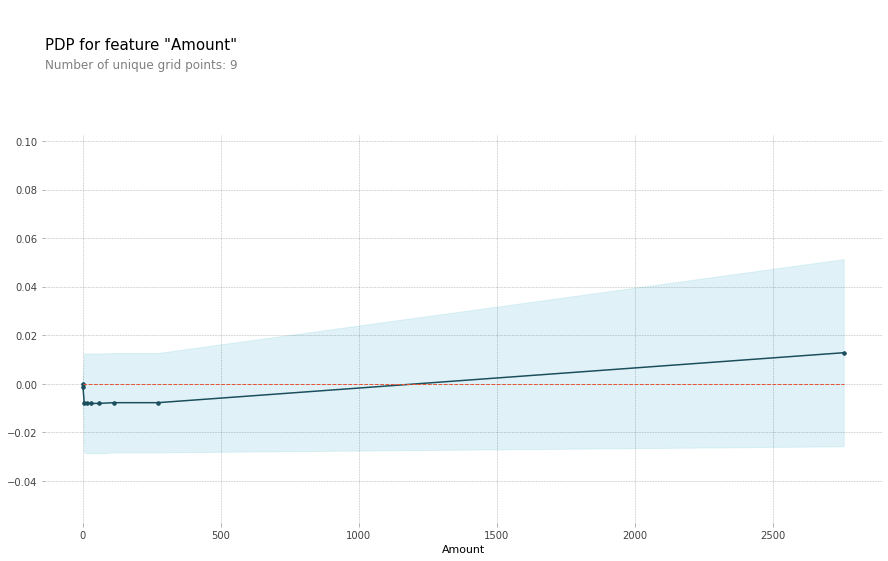

In [102]:
from pdpbox.pdp import pdp_isolate, pdp_plot,pdp_interact, pdp_interact_plot

isolated = pdp_isolate(xg_pipe,X_train_down,X_train_down.columns,'Amount')

pdp_plot(isolated, 'Amount')

# 피쳐하나와 타겟과의 상관관계 그래프 x축이 피쳐, y축이 타겟이다 
# 거래금액이 많을 수록 사기거래에 가깝다는 것을 확인 할 수 있다 

(<Figure size 540x684 with 3 Axes>,
 {'pdp_inter_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7fefcfd724d0>,
  'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7fefcfdb1450>})

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


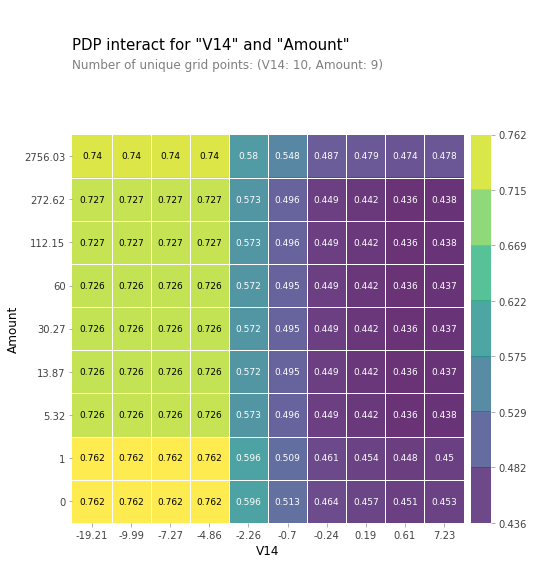

In [103]:
# 피쳐 두개의 상관관계 plot
features = ['V14','Amount']

interaction = pdp_interact(xg_pipe,X_train_down,X_train_down.columns,features)

pdp_interact_plot(interaction, plot_type='grid',
                  feature_names=features)

# V14값이 음수일때 거래금액이 적어도 사기일 확률이 높고, V14값이 커질수록 거래금액도 같이 커져야 사기일 확률이 높다 

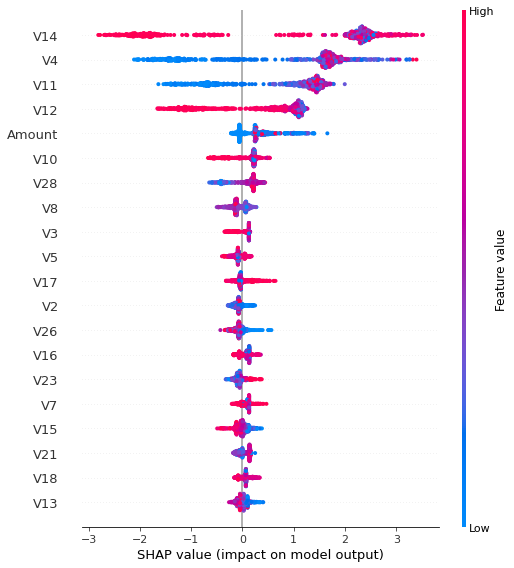

In [104]:
# shap을 사용해 모든 피쳐 끼리의 상관관계 시각화

shap.initjs()

explainer = shap.TreeExplainer(xg_tuning)
shap_values = explainer.shap_values(X_train_down)

#shap.force_plot(explainer.expected_value,shap_values,X_train_down)

shap.summary_plot(shap_values, X_train_down)

- shap은 특성 기여도를 기반으로 두고 중요도를 골라낸다 상단의 summary plot은 피쳐값의 변화에 따라 피쳐가 얼마나 중요한지를 보여준다 

- X축은 해당 피쳐값이 예측값에 플러스인지 마이너스 요소인지 알려준다 

- 예를 들면 v14피쳐에서 낮은 피쳐값은 예측값을 높이는 역할을 한다, 즉 사기거래로 예측할 확률이 플러스 되는 요소이다 반면 높은 피쳐값은 분포가 다양해서 별로 변별력이 없어 보인다 

- 반대로 V4와 Amount 피쳐는 높은 피쳐값이 사기거래로 예측하는데 플러스 영향을 준다 

*++추가로 로지스틱모델로 시각화를 하고 싶었으나 데이터가 커서 코랩이 자꾸 다운되어 xgboost모델로 시각화를 했습니다.. (shap이 생각보다 너무 무겁네요)*

모델이 관측치를 예측하기 위해서 어떤 특성을 활용했나요?
- 위에서 설명함 

어떤 특성이 있다면 모델의 예측에 도움이 될까요? 해당 특성은 어떻게 구할 수 있을까요?
- 개인정보 때문에 피쳐 이름이 가려져 있어서 대략 어떤 피쳐들이었을 것이다라고 나의 생각을 적자면. 카드단말기, 거래한 가게, 거래위치, 카드 종류, 나이, 최근몇개월간 사용량 등이 있었을것 같다. 거래정보는 카드사에서 관리 하기 때문에 웬만한 정보는 전부 카드사 내부에서 구할 수 있을것 같다 

실제로는 실시간으로 거래가 이루어지기 때문에 실시간 데이터를 받아 새로운 이상 패턴을 빨리 익혀서 사기탐지를 하는 것이 중요한 분야이며, 나중에 딥러닝을 배우면 더 나은 다른 방법으로 또 모델을 만들어 보고싶다 
